Link de la presentación: 
https://www.canva.com/design/DAFeCjArLw4/3XnYvJBzbpoGrMTpJg-FMw/view?utm_content=DAFeCjArLw4&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

In [1]:
# Importar librerías:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import geopandas as gpd
from apyori import apriori
from collections import Counter
from wordcloud import WordCloud 
from dateutil.parser import parse 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 120})
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Cargar dataset
data = pd.read_csv('ds_onlineRetail.csv', encoding='ISO-8859-1')
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Eliminar filas sin países
data = data.loc[(data['Country'] != "Unspecified")] 
# Calculo las ventas totatles
data['VentasTotales'] = data.Quantity * data.UnitPrice
data.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerI

In [4]:
data.describe()

,Quantity,UnitPrice,CustomerID,VentasTotales
count,541463.000000,541463.000000,406585.000000,541463.000000
mean,9.554023,4.612688,15288.630473,17.993839
std,218.170802,96.799645,1713.284209,378.966647
min,-80995.000000,-11062.060000,12346.000000,-168469.600000
25%,1.000000,1.250000,13956.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [5]:
#data.UnitPrice.sort_values
len(data[data["UnitPrice"]<0])

2

## Gráficos

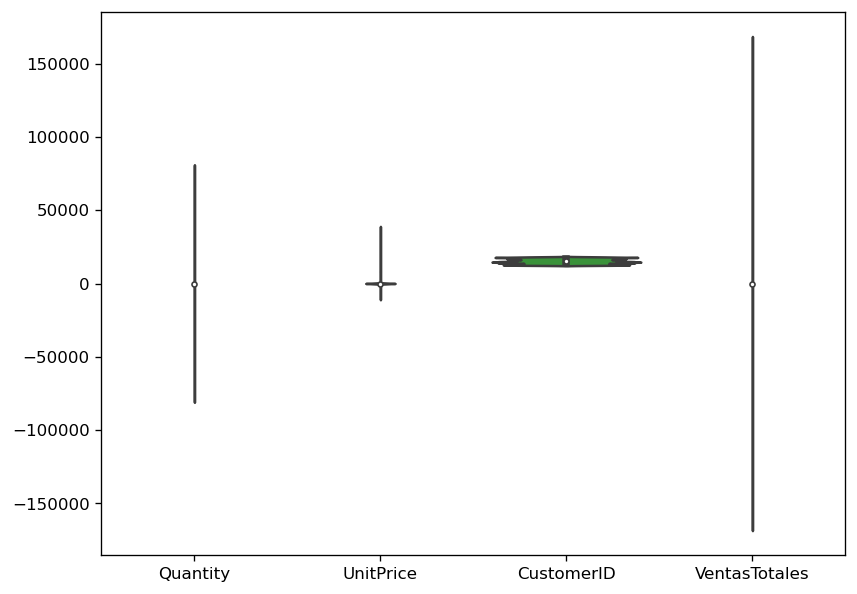

In [6]:
# Distribución de las variables
sns.violinplot(data=data)
#plt.title("Escala de los datos")
plt.show()

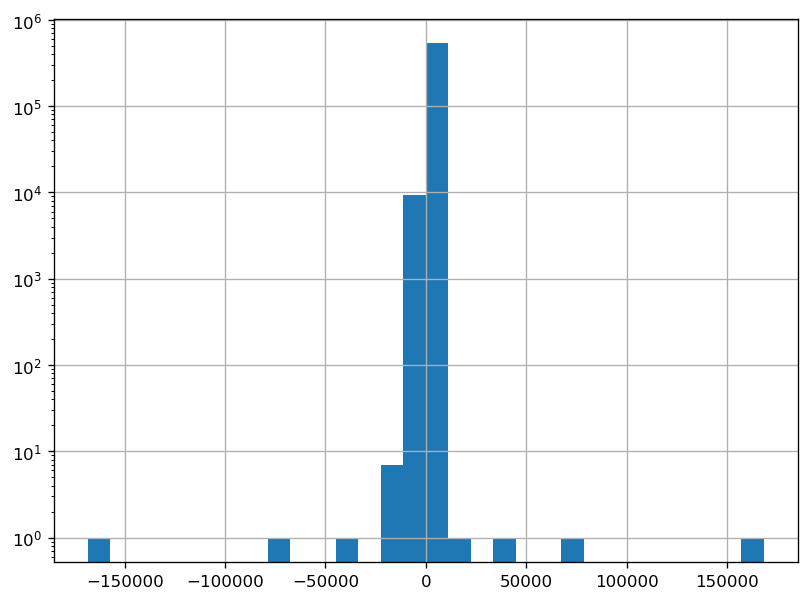

In [7]:
# Historama de Vental Total (30 días = 1 mes), hay muchas ventas están ubicadas entre 0 y 100 000
data.VentasTotales.hist(bins=30)
#plt.title("Ventas Totales")
plt.yscale('log')
# Casi todas compras de cosas cerca a cero

In [8]:
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha de minutos/segundos 
data['Date'] = data['InvoiceDate'].dt.date
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,VentasTotales,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


<function matplotlib.pyplot.show(close=None, block=None)>

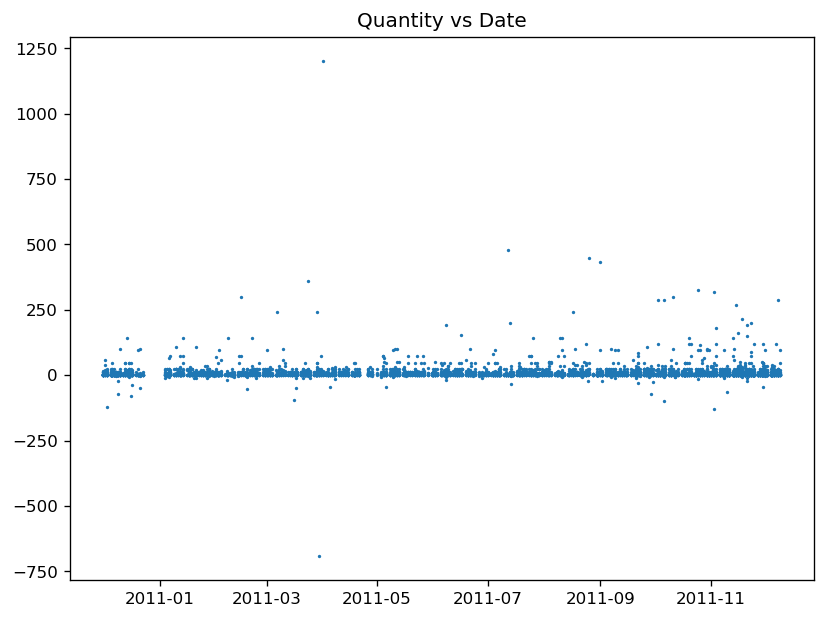

In [9]:
# Distribución a lo largo del tiempo (el proceso de venta está estable en el tiempo)
dataShort = data[::100]
plt.scatter(dataShort["Date"], dataShort["Quantity"] , s=1)
plt.title("Quantity vs Date")
plt.show
# Conforme pasa el tiempo no se vende más ni menos

Text(0.5, 1.0, 'Variación del CustomerID')

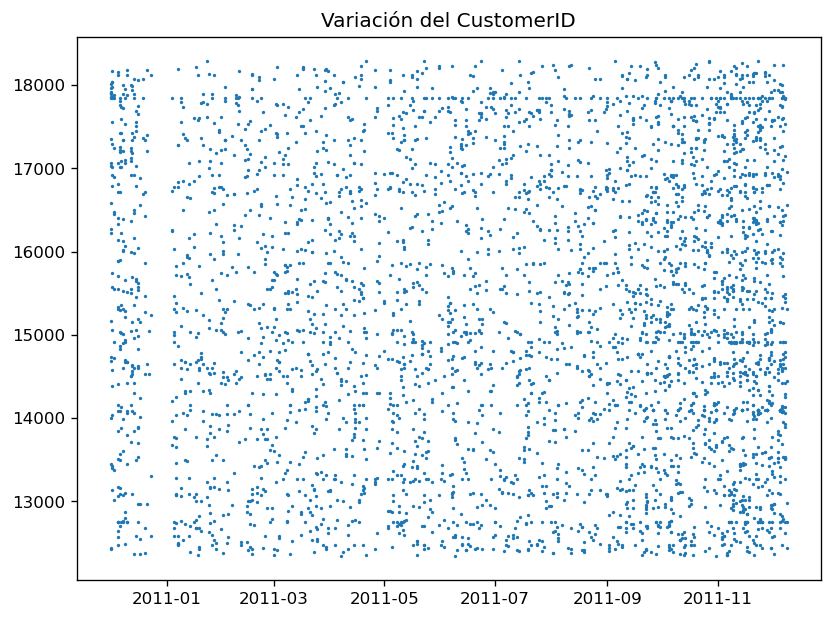

In [10]:
plt.scatter(dataShort["Date"], dataShort["CustomerID"], s=1)
plt.title("Variación del CustomerID")
# No hay variación en el rago del tiempo, es una continuación, no hay tendencia ( es constante) No hay aumento de la catn de ctes. 

Text(0.5, 1.0, 'Mapa de Correlación')

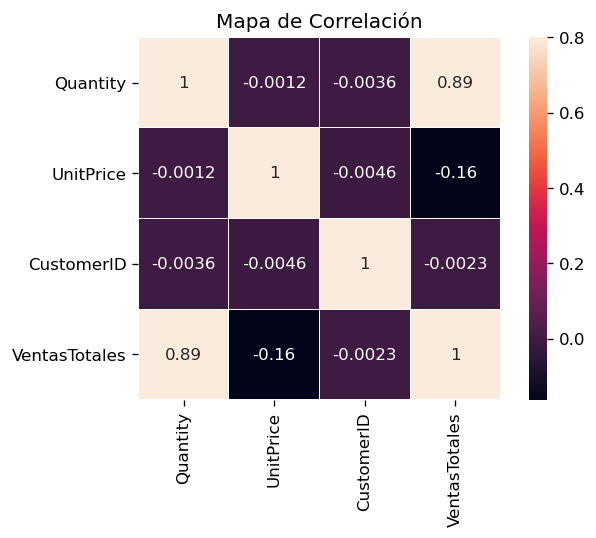

In [11]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)
plt.title("Mapa de Correlación")
# Hay una relación fuerte entre la venta total y quantily 

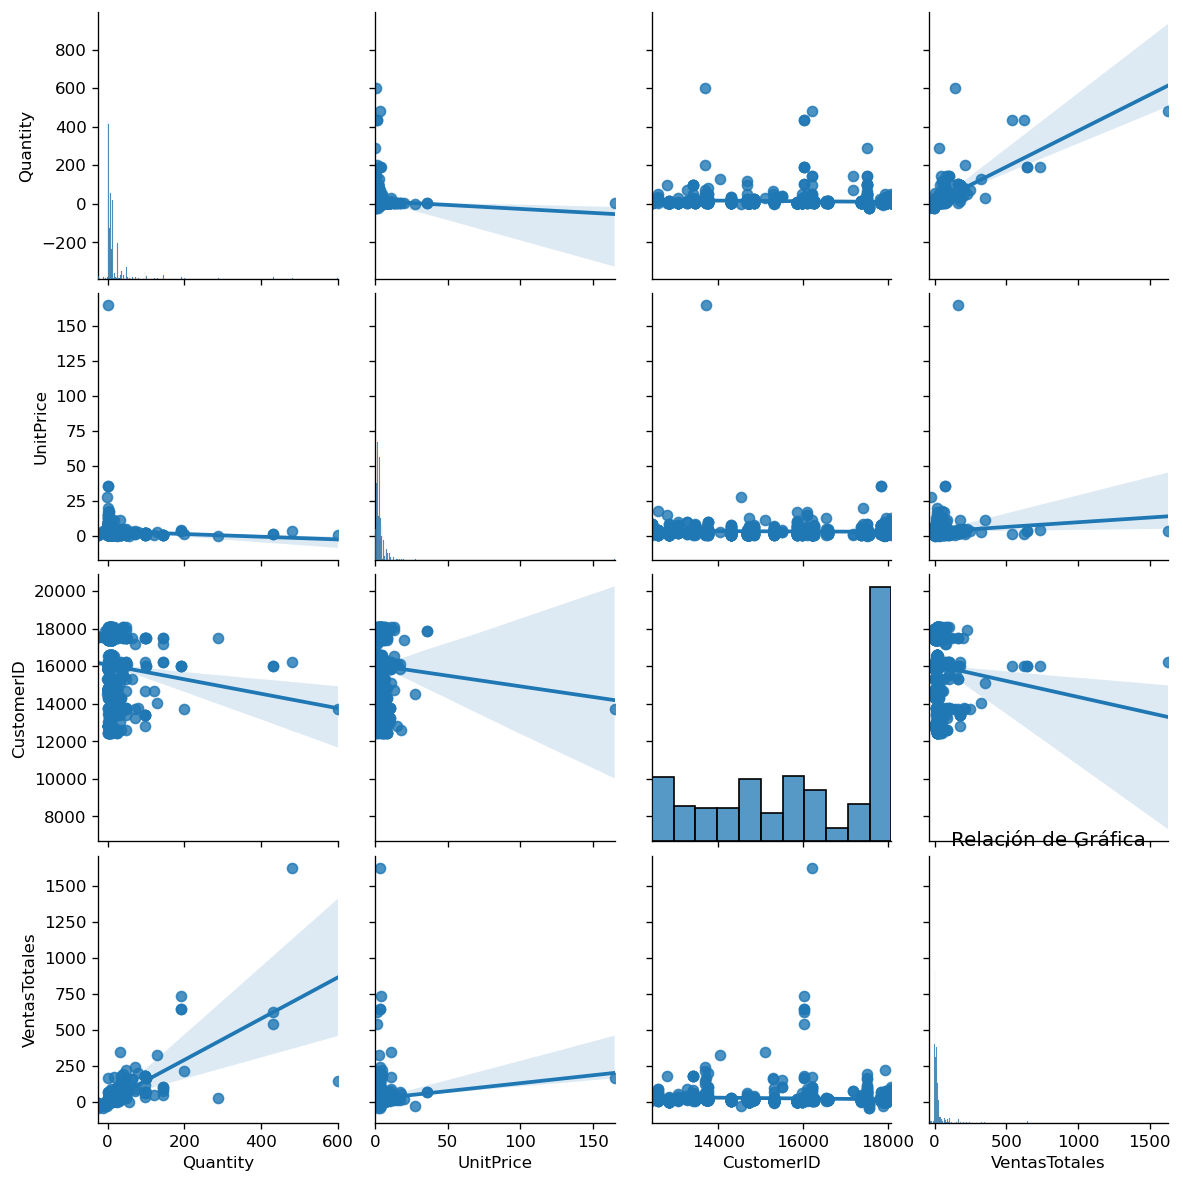

In [12]:
# Seaborn o PairGrid:
sns.pairplot(data[:1000], kind="reg")
plt.title("Relación de Gráfica")
plt.show()
# Más detalle de la correlación. 
# En la 1° gráfico muestra la relación de la cantidad de las compras.
# La gráfica muestra que lso clientes son los más recientes.

In [13]:
paises = ['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Brazil', 'United States of America',
       'European Community', 'Malta', 'RSA']
df = pd.DataFrame(paises,columns=['paises x filtrar'])


Channel Islands united king
Bahrain emiratos 
Hong Kong china
Singapore malasia
Czech Republic Czech of Republic 
European Community - 
Malta - 

In [14]:
#data['Country'].unique()
len(data['Country'].unique())

37

In [15]:
#buscar_data = paises_geo_pandas['name'].str.contains('Fra') == True
#data['Country'].unique()
#paises_geo_pandas['name'].unique()
#paises_geo_pandas[paises_geo_pandas['name'] == 'Czech of Republic']
df['paises x filtrar'].str.contains("|".join(paises_geo_pandas['name']))
df_nuevo = df[df['paises x filtrar'].str.contains("|".join(paises_geo_pandas['name']))==False]
df_nuevo

NameError: name 'paises_geo_pandas' is not defined

In [ ]:
data['Country'].unique()
#paises_geo_pandas.name.sort_values
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Czechia"]

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Brazil', 'USA', 'European Community',
       'Malta', 'RSA'], dtype=object)

In [ ]:
data['Country'] = data['Country'].apply(lambda x : x.replace("EIRE", "Ireland"))
data['Country'] = data['Country'].apply(lambda x : x.replace("RSA", "Russia"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Hong Kong", "China"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Singapore", "Malaysia"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Czech Republic", "Czechia"))
data['Country'] = data['Country'].apply(lambda x : x.replace("USA", "United States of America"))
data['Country'] = data['Country'].apply(lambda x : x.replace("Channel Islands", "United Kingdom"))
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'Ireland', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'China', 'Malaysia',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia', 'Czechia',
       'Canada', 'Brazil', 'United States of America',
       'European Community', 'Malta', 'Russia'], dtype=object)

In [ ]:
vtas_totales_paises = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
vtas_totales_paises = vtas_totales_paises.sort_values('venta_total',ascending=False)
vtas_totales_paises["logVentaTotal"] = np.log10(vtas_totales_paises["venta_total"])
vtas_totales_paises

,Country,Quantity,UnitPrice,CustomerID,venta_total,logVentaTotal
35,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,6.913168
25,Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05,5.454329
17,Ireland,142637,4.844719e+04,1.103917e+08,2.632768e+05,5.420413
14,Germany,117448,3.766600e+04,1.200751e+08,2.216982e+05,5.345762
13,France,110480,4.303199e+04,1.076489e+08,1.974039e+05,5.295356
0,Australia,83653,4.054750e+03,1.569300e+07,1.370773e+05,5.136965
33,Switzerland,30325,6.813690e+03,2.377592e+07,5.638535e+04,4.751166
31,Spain,26824,1.263345e+04,3.268929e+07,5.477458e+04,4.738579
3,Belgium,23152,7.540130e+03,2.571829e+07,4.091096e+04,4.611840
32,Sweden,35637,1.806830e+03,6.790083e+06,3.659591e+04,4.563433


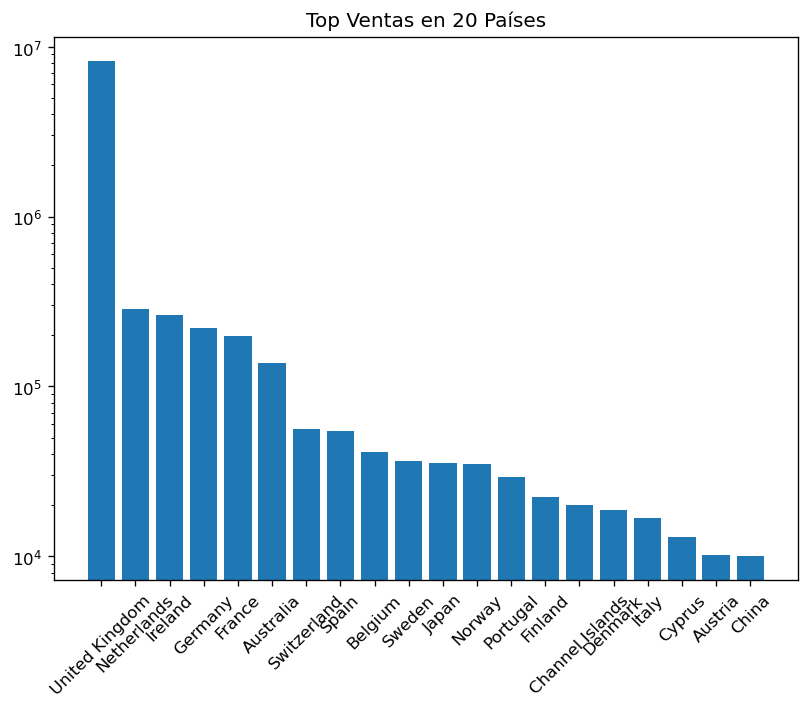

In [ ]:
# Reducir para mostrar los 20 primeros
vtas_totales_paises_ = vtas_totales_paises[:20]
# Crear la gráfica de barras
plt.bar(vtas_totales_paises_.Country, vtas_totales_paises_['venta_total'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Top Ventas en 20 Países")
plt.show()

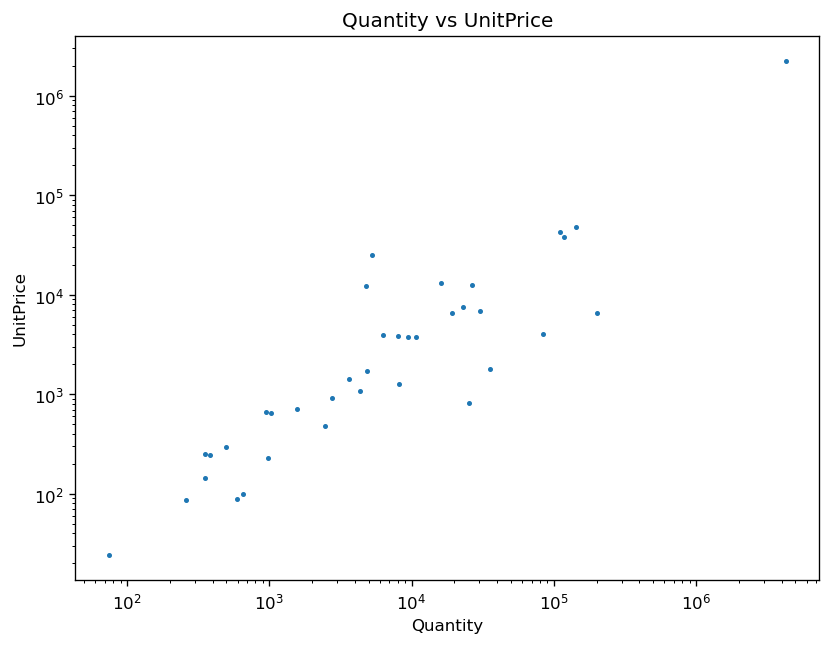

In [ ]:
# Gráfica de dispersión (scatter) de Quantity vs UnitPrice 
plt.scatter(vtas_totales_paises['Quantity'], vtas_totales_paises['UnitPrice'], s=4)
plt.title("Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.xscale('log')
plt.yscale('log')
plt.show()
# Cuándo se compran grandes cantidad es de precio alto.

In [ ]:
titles=''.join(str(data.Description)).lower()
titles

"0          white hanging heart t-light holder\n1                         white metal lantern\n2              cream cupid hearts coat hanger\n3         knitted union flag hot water bottle\n4              red woolly hottie white heart.\n                         ...                 \n541904            pack of 20 spaceboy napkins\n541905           children's apron dolly girl \n541906          childrens cutlery dolly girl \n541907        childrens cutlery circus parade\n541908          baking set 9 piece retrospot \nname: description, length: 541463, dtype: object"

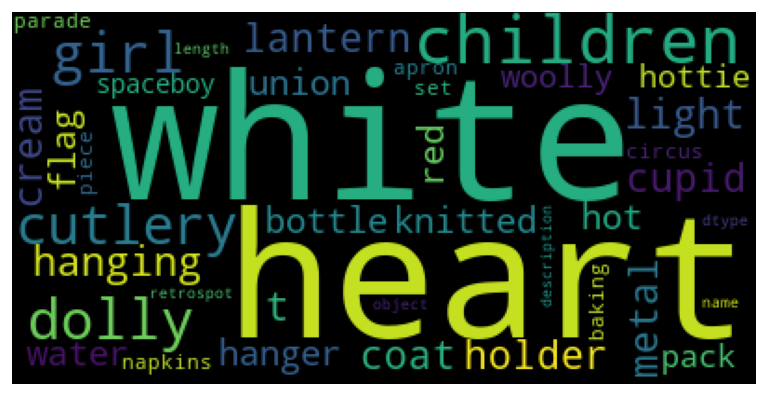

In [ ]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [ ]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Listado completo: pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
                 ...           
172                      Serbia
173                  Montenegro
174                      Kosovo
175         Trinidad and Tobago
176                    S. Sudan
Name: name, Length: 177, dtype: object>

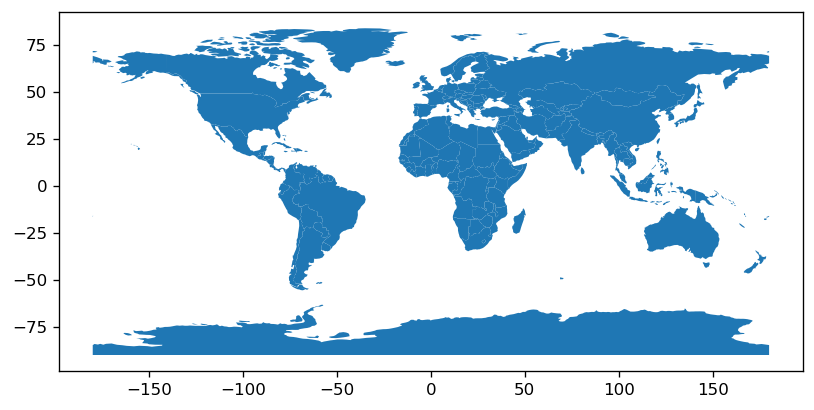

In [ ]:
# Verificar si coincide los nombre de países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
plt.show()   

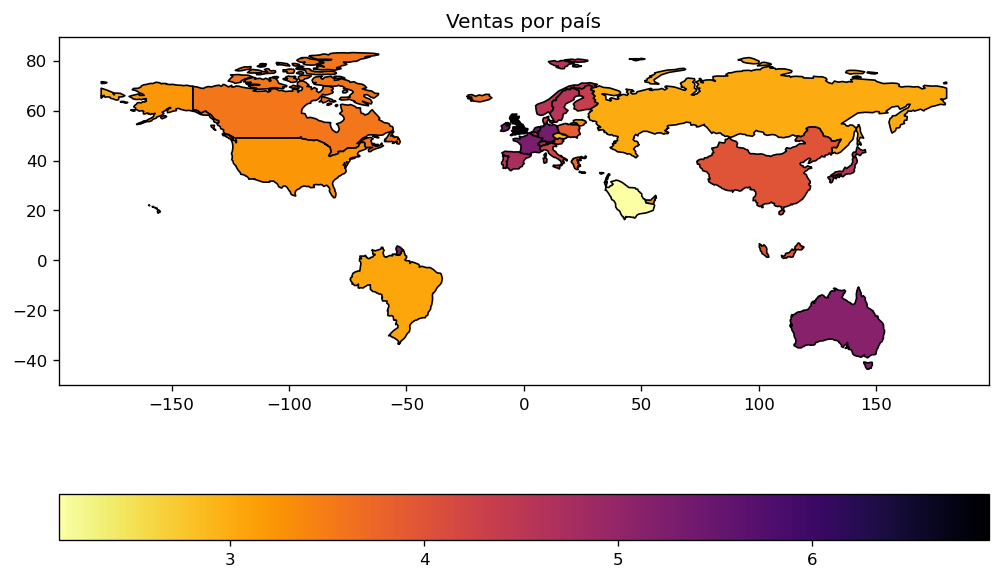

In [ ]:
# Unir los datos de los países con los datos de ventas por país
data_merge = paises_geo_pandas.merge(vtas_totales_paises, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar los países en el mapa y colorearlos según las ventas
data_merge.plot(ax=ax, column='logVentaTotal', cmap='inferno_r', linewidth=0.99, edgecolor='black', legend=True, legend_kwds={'orientation': "horizontal"})
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [ ]:
# horas = pd.date_range(start=data['minutos_segundos'].min(),end=data['minutos_segundos'].max())
# Calendario de Ventas Mensuales:
calendario_cant_vta = data.groupby(['Date'], group_keys=False, as_index=False).sum('Quantity')
calendario_cant_vta
#print(calendario_cant_vta[calendario_cant_vta['Quantity'] < 0])

,Date,Quantity,UnitPrice,CustomerID,venta_total
0,2010-12-01,26814,12904.25,30821613.0,58635.56
1,2010-12-02,21023,6815.68,32921050.0,46207.28
2,2010-12-03,14830,11114.09,17091533.0,45620.46
3,2010-12-05,16395,7893.17,41415197.0,31383.95
4,2010-12-06,21419,17678.78,31409278.0,53860.18
...,...,...,...,...,...
300,2011-12-05,44119,57195.74,51763938.0,57751.32
301,2011-12-06,29026,10364.64,41776904.0,54228.37
302,2011-12-07,39612,9049.19,33953553.0,75076.22
303,2011-12-08,34460,21808.10,39236168.0,81417.78


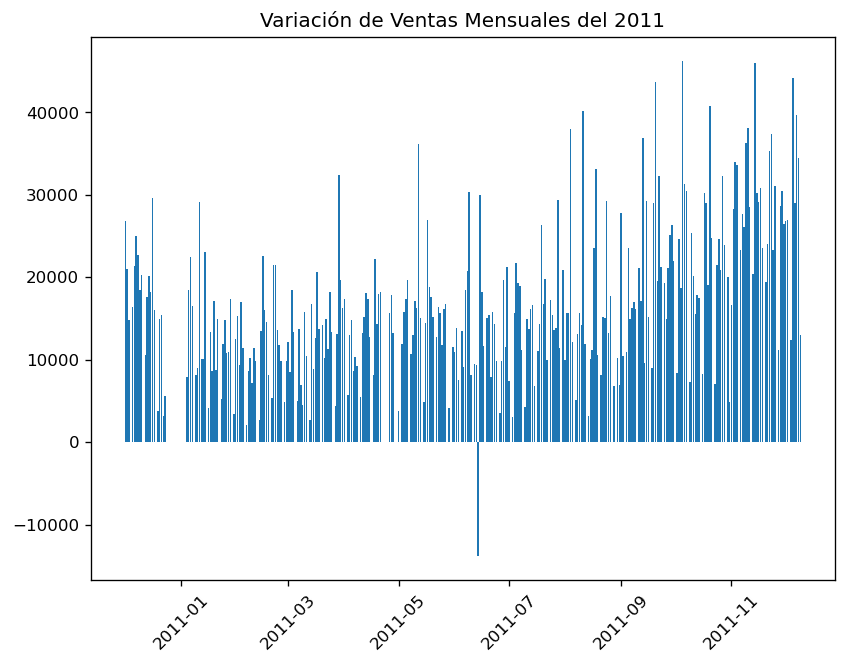

In [ ]:
# Representación de la cant vs la fecha 
plt.bar(calendario_cant_vta.Date, calendario_cant_vta['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Variación de Ventas Mensuales del 2011")
plt.show()

In [ ]:
# Calendario de ventas:
ventas_totales_factura = data.groupby(['InvoiceDate'], group_keys=False, as_index=False).sum('venta_total')
ventas_totales_factura = ventas_totales_factura[::10]
ventas_totales_factura = ventas_totales_factura.sort_values('InvoiceDate',ascending=True)
# horario_ventas_totales = horario_ventas_totales[:10]
ventas_totales_factura['Hora'] = ventas_totales_factura['InvoiceDate'].dt.hour
ventas_totales_factura.head(2)

,InvoiceDate,Quantity,UnitPrice,CustomerID,venta_total,Hora
0,2010-12-01 08:26:00,40,27.37,124950.0,139.12,8
10,2010-12-01 09:34:00,12,3.70,35700.0,22.20,9


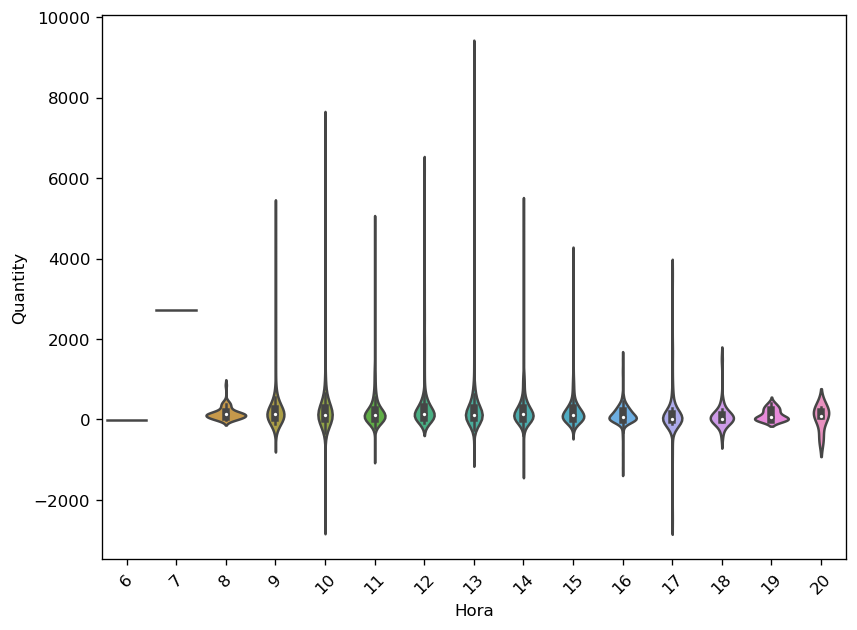

In [ ]:
# Disribución por horas y densidad
sns.violinplot(x="Hora", y="Quantity", data=ventas_totales_factura)
plt.xticks(rotation=45)
plt.show()

In [ ]:
horario_ventas_totales = ventas_totales_factura.groupby(['Hora'], group_keys=False, as_index=False).sum('venta_total')

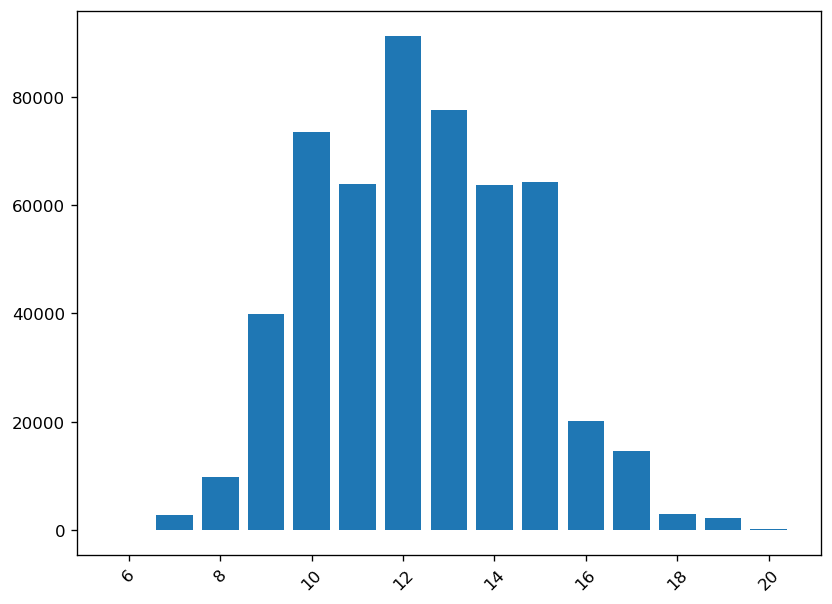

In [ ]:
# Gráfico de calendario de horario de ventas:
plt.bar(horario_ventas_totales.Hora, horario_ventas_totales['Quantity'])
# plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [ ]:
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['StockCode'], aggfunc=np.sum)
Customer_Item.fillna(value=0, inplace=True)
Customer_Item

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


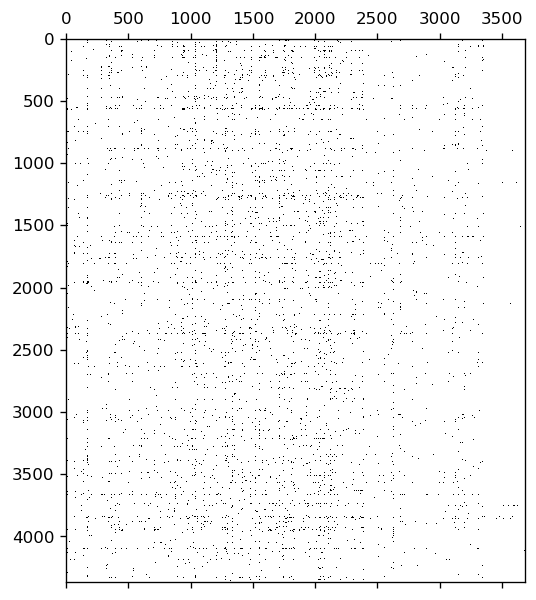

In [ ]:
# Matriz para verificar queno todos los valores son NaN
plt.spy(Customer_Item)
plt.show()

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [ ]:
userUser = pd.DataFrame(cosine_similarity(Customer_Item))
userUser.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
1,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.023478,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.07451,0.108942


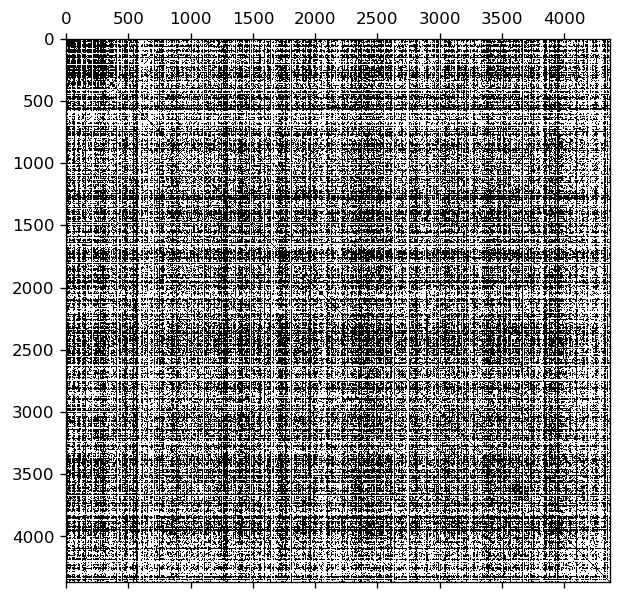

In [ ]:
# Calculando la cantidad de usuarios. Matriz de user vs user:
userUser.shape
plt.spy(userUser)
plt.show()

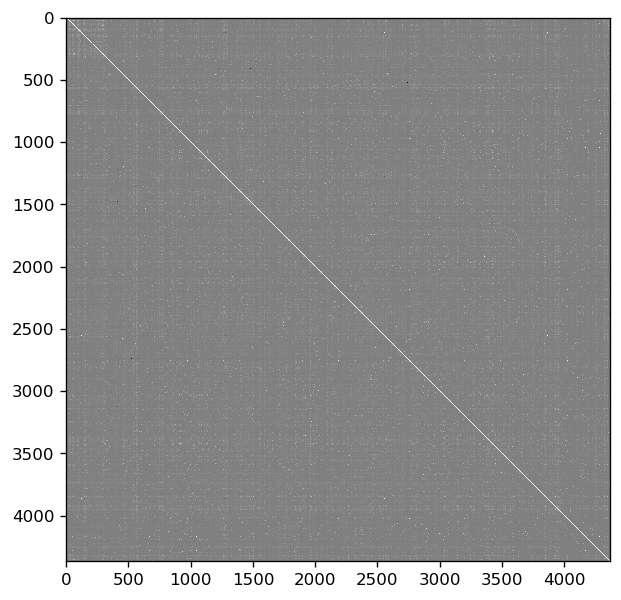

In [ ]:
# Graficar matriz densa
plt.imshow(userUser, cmap='gray', interpolation='nearest')
plt.show()

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

In [ ]:
userUser.columns = Customer_Item.index
userUser.index = Customer_Item.index
userUser.head(2)

CustomerID,12346.0,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
12347.0,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.023478,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.07451,0.108942


In [ ]:
userUser.iloc[1]

CustomerID
12346.0    0.000000
12347.0    1.000000
12348.0    0.148879
12349.0    0.020750
12350.0    0.014435
             ...   
18280.0    0.037236
18281.0    0.000000
18282.0    0.011921
18283.0    0.074510
18287.0    0.108942
Name: 12347.0, Length: 4368, dtype: float64

In [ ]:
filtrado = userUser.iloc[1]
ranking = filtrado.sort_values(ascending = False)
ranking = ranking.iloc[1:11] 
ranking

CustomerID
14326.0    0.552321
12674.0    0.540213
14257.0    0.532188
12355.0    0.506252
16763.0    0.427693
16761.0    0.427193
13532.0    0.410891
18276.0    0.407060
12452.0    0.385802
17242.0    0.384841
Name: 12347.0, dtype: float64

In [ ]:
similares = ranking[(ranking > 0) & (ranking < 1)]
top_10 = similares.head(10)
top_10

CustomerID
14326.0    0.552321
12674.0    0.540213
14257.0    0.532188
12355.0    0.506252
16763.0    0.427693
16761.0    0.427193
13532.0    0.410891
18276.0    0.407060
12452.0    0.385802
17242.0    0.384841
Name: 12347.0, dtype: float64

In [ ]:
Customer_Item.loc[list(top_10.index)]

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
14326.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12674.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
14257.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16763.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13532.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18276.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
sum_total_products_similar_customer = Customer_Item.loc[list(top_10.index)].sum()
sum_total_products_similar_customer.sort_values(ascending = False).head(10)

StockCode
23076    816.0
22492    252.0
23077    180.0
23084     84.0
22418     72.0
22614     71.0
20725     60.0
20728     50.0
84946     48.0
21122     48.0
dtype: float64

In [ ]:
descripciones = pd.pivot_table(data, values='Description', index=['StockCode'], aggfunc=np.sum)
descripciones

,Description
StockCode,
10120,DOGGY RUBBERDOGGY RUBBERDOGGY RUBBERDOGGY RUBB...
10123G,0
10124A,SPOTS ON RED BOOKCOVER TAPESPOTS ON RED BOOKCO...
10124G,ARMY CAMO BOOKCOVER TAPEARMY CAMO BOOKCOVER TA...
10125,MINI FUNKY DESIGN TAPESMINI FUNKY DESIGN TAPES...
...,...
S,SAMPLESSAMPLESSAMPLESSAMPLESSAMPLESSAMPLESSAMP...
gift_0001_20,Dotcomgiftshop Gift Voucher £20.00Dotcomgiftsh...
gift_0001_40,Dotcomgiftshop Gift Voucher £40.00Dotcomgiftsh...


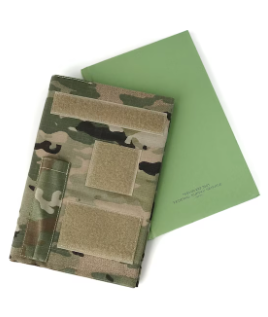  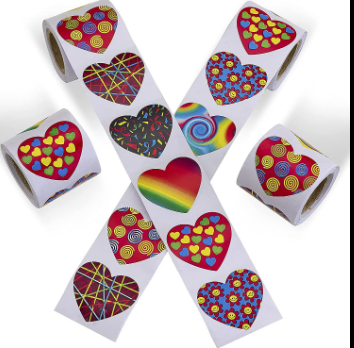 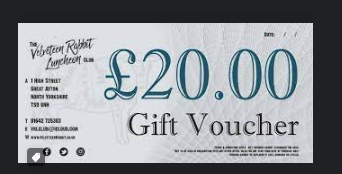

7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

In [ ]:
ItemUser = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['Description'], aggfunc=np.sum)
ItemUser.fillna(value=0, inplace=True)
ItemUser.head(2)
# Buscar el cliente de posición: 12346.0

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Item_Item = pd.DataFrame(cosine_similarity(ItemUser))
Item_Item.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.022843,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.075245,0.108942


In [ ]:
ItemUser[ItemUser.index == 12347.0]

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

In [ ]:
# Lista stopwords en inglés
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "something", "doesn", "even", "article", "behind", "much", "towards", "next", "since", "upon", "a", "s", "the", "to", "and", "in", "of", "is", "you", "for", "on", "it", "my", "that", "with", "be", "this", "at", "me", "was", "like", "so", "but", "just", "have", "are", "he", "from", "all", "not", "if", "can", "we", "your", "as", "one", "by", "out", "up", "will", "when", "about", "new", "what", "an", "get", "they", "his", "now", "has", "do", "love", "or", "don", "no", "who", "good", "her", "more", "know", "see", "how", "there", "day", "she", "time", "go", "think", "would", "lol", "people", "got", "re", "today", "only", "some", "movie", "back", "great", "going", "over", "world", "had", "our", "want", "watching", "best", "why", "really", "him", "life", "still", "make", "ll", "last", "first", "been", "right", "its", "should", "us", "too", "games", "after", "into", "big", "top", "before", "news", "video", "case", "court", "team", "does", "bang", "watch", "off", "white", "times", "turns", "man", "press", "heart", "free", "three", "black", "clubs", "home", "city", "teen", "shortly", "flight", "left", "match", "girls", "did", "done", "cannot", "again", "become", "never", "found", "better", "than", "other", "which", "even", "also", "same", "these", "though", "both", "their", "most", "much", "very", "any", "take", "almost", "may", "ever", "while", "made", "own", "where", "here", "view", "using", "during", "along", "through", "seen", "used", "year", "says", "long", "years", "old", "could", "pm", "ago", "week", "full", "next", "find", "live", "minute", "high", "need", "things", "site", "down", "look", "were", "say", "said", "search", "minutes", "inside", "rights", "reserved", "com", "post", "against", "two", "ahead", "least", "latest", "under", "then", "sees", "way", "being", "beyond", "part", "near", "daily", "photo", "making", "am", "read", "th", "around", "keep", "behind", "makes", "takes", "since", "them", "those", "wants", "move", "gets", "another", "saying", "doesn", "without", "every", "getting", "once", "might", "away", "put", "come", "didn", "many", "himself", "hasn", "such", "well", "because", "something", "use", "until", "wrong", "each", "below", "sure", "try", "must", "went", "between", "set", "however", "including", "became", "known", "text", "fig", "worth", "exactly", "enough", "quite", "aren", "across", "according", "within", "few", "lot", "among", "little", "doing", "yet", "per", "various", "whether", "further", "onto", "currently", "fast", "above", "otherwise", "although", "unlike", "together", "latestly", "aforementioned", "online", "information", "email", "copyright", "hours", "please", "english", "language", "click", "help", "privacy", "contact", "terms", "page", "policy", "account", "share", "service", "address", "work", "media", "follow", "blog", "money", "show", "reply", "add", "sign", "link", "posted", "content", "stay", "use", "users", "app", "website", "support", "via", "real", "web", "ad", "send", "download", "data", "the", "of", "and", "a", "in", "to", "it", "is", "was", "to", "i", "for", "you", "he", "be", "with", "on", "that", "by", "at", "are", "not", "this", "but", "s", "they", "his", "from", "had", "she", "which", "or", "we", "an", "were", "that", "been", "have", "their", "has", "would", "what", "will", "there", "if", "can", "all", "her", "as", "who", "have", "do", "that", "one", "said", "them", "some", "could", "him", "into", "its", "then", "two", "when", "up", "time", "my", "out", "so", "did", "about", "your", "now", "me", "no", "more", "other", "just", "these", "also", "people", "any", "first", "only", "new", "may", "very", "should", "as", "like", "her", "than", "as", "how", "well", "way", "our", "as", "between", "years", "er", "many", "those", "there", "ve", "being", "because", "based", "million", "different", "number", "provide", "access", "country", "end", "available", "report", "open", "days", "already", "working", "called", "receive", "process", "create", "able", "power", "change", "experience", "important", "told", "second", "current", "major", "order", "example", "level", "key", "neither", "direct", "nor", "directly", "indirectly", "mentioned", "disclaimer", "caused", "purposed", "details", "non", "vs", "built", "offs", "feel", "third", "solution", "user", "existing", "capable", "less", "instead", "whereas"]

In [ ]:
# Extraemos las palabras  
contador = CountVectorizer() 
vectorizador = TfidfVectorizer(stop_words = stopwords)  
vectorizador

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', 'your', 'yours', 'yourself',
                            'yourselves', 'he', 'him', 'his', 'himself', 'she',
                            'her', 'hers', 'herself', 'it', 'its', 'itself',
                            'they', 'them', 'their', 'theirs', 'themselves',
                            'what', ...])

In [ ]:
# Crear una matriz dispersa
cantidades = contador.fit_transform(ItemUser.columns)
valores = vectorizador.fit_transform(ItemUser.columns)
# Generate matrix of word vectors
tfidf_matrix = vectorizador.fit_transform(ItemUser.columns)
tfidf_matrix.shape

(3896, 1946)

In [ ]:
tokens = vectorizador.get_feature_names()
tokens

['10',
 '11',
 '12',
 '120cm',
 '125g',
 '15',
 '15c',
 '15cm',
 '16',
 '16x16cm',
 '17080',
 '18pc',
 '20',
 '200',
 '20light',
 '21',
 '23',
 '24',
 '250g',
 '25w',
 '25x24x12cm',
 '30',
 '30cm',
 '30cmx30cm',
 '34x20cm',
 '35',
 '36',
 '3d',
 '40',
 '40cm',
 '40x40cm',
 '42',
 '45cm',
 '45x30cm',
 '45x45cm',
 '50',
 '500g',
 '50cm',
 '5g',
 '60',
 '60cm',
 '60x40cm',
 '65cmx65cm',
 '6pc',
 '70',
 '72',
 '75',
 '78',
 '8m',
 'a4',
 'a5',
 'a6',
 'a7',
 'abc',
 'abstract',
 'acapulco',
 'acrylic',
 'ade',
 'adult',
 'advent',
 'afghan',
 'aged',
 'ahoy',
 'aid',
 'air',
 'airline',
 'airmail',
 'alarm',
 'album',
 'allium',
 'alphabet',
 'alpine',
 'aluminium',
 'amber',
 'amelie',
 'amethyst',
 'anemone',
 'angel',
 'angels',
 'animal',
 'animals',
 'ant',
 'antique',
 'antoienett',
 'antoinette',
 'aperitif',
 'apothecary',
 'apple',
 'apples',
 'apron',
 'aqua',
 'area',
 'army',
 'art',
 'articulated',
 'artificial',
 'artiifcial',
 'ashtray',
 'ass',
 'assorted',
 'asst',
 'asstd

In [ ]:
# 3.- Le paso una recomendacion
recomendacionrecomendacion = "PACK OF 20 SPACEBOY NAPKINS"

'PACK OF 20 SPACEBOY NAPKINS'

In [ ]:
preguntaVector = vectorizador.transform([recomendacion])
preguntaVector

<1x1946 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# print(preguntaVector)
def vector2df(vector, tokens):
    dfPregunta = pd.DataFrame()
    # Obtener la frecuencia de cada token en la pregunta
    frecuencias = np.array(vector.sum(axis=0))[0]
    # Imprimir los tokens y sus frecuencias
    # La función zip(tokens, frecuencias) combina las listas tokens y frecuencias para formar una secuencia de tuplas
    for token, frecuencia in zip(tokens, frecuencias):
        if frecuencia > 0:
            # print(token, frecuencia)
            dfPregunta.loc[token, "frecuencia"] = frecuencia
    dfPregunta = dfPregunta.sort_values("frecuencia", ascending=False)
    return dfPregunta
vector2df(preguntaVector, tokens)

,frecuencia
napkins,0.567461
20,0.541842
spaceboy,0.465064
pack,0.410013


In [ ]:
coseno_similares = cosine_similarity(preguntaVector, tfidf_matrix)
# Obtener el índice de los 10 mayores números de una lista de los productos que más se parecen 
mejores_resultados = np.argsort(coseno_similares)[0]
mejores_resultados = np.flip(mejores_resultados)[:100] # inverse rearrange on numpy
mejores_resultados

array([2263, 2228, 2260, 2261, 2262, 3009, 3120, 3119, 2955, 2227, 2252,
       2278, 3142, 3335, 3670, 3324,   38, 3329, 3330, 3325,  272,  710,
       3326, 3327,  706, 2053, 1774, 1956,    9, 3008,  697, 1799, 3331,
       2583, 3470, 3332,   30,  714,  692, 2945, 3328, 3032,  699, 3037,
       2964,   12,  231, 2063, 3334, 1980, 1986, 1985,   48, 2259, 2245,
       2248, 2250, 1987, 2256, 2242, 2251, 2235, 1988, 2247, 3333, 2238,
       2266, 2241, 2254, 2271, 2272, 2258, 2244, 2231, 2232, 2257, 2273,
       2267, 2237, 2282, 1989, 2243, 2269, 2268, 2236, 2279, 2230, 2229,
       2249, 2239, 2274, 2255, 2277, 2253, 2234, 2280, 2246, 2275,  959,
       2264], dtype=int64)

In [ ]:
for i in mejores_resultados:
    print(i)
    print(coseno_similares[0][i])
    # Obtener el vector de características del documento de interés
    vector_documento = tfidf_matrix[i]
    print(vector2df(vector_documento, tokens)[:5])
print(recomendacion)
print("\n")

2263
1.0
          frecuencia
napkins     0.567461
20          0.541842
spaceboy    0.465064
pack        0.410013
2228
0.7503521226566541
         frecuencia
napkins    0.543303
20         0.518776
pack       0.392558
paper      0.381599
rose       0.368746
2260
0.732726872134
         frecuencia
napkins    0.530542
20         0.506590
pantry     0.445701
pack       0.383337
design     0.341021
2261
0.7182832715906836
         frecuencia
napkins    0.520084
apples     0.501827
20         0.496604
pack       0.375781
red        0.299760
2262
0.7134075188697957
         frecuencia
napkins    0.516553
20         0.493233
skull      0.467934
pack       0.373230
paper      0.362810
3009
0.670567482977377
           frecuencia
napkins      0.618125
20           0.590219
christmas    0.383649
vintage      0.349823
3120
0.6092764919437899
            frecuencia
napkins       0.561627
20            0.536272
strawberry    0.491306
paper         0.394469
3119
0.6060703697276784
           frecuen

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.

In [ ]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134878
Country             0
venta_total         0
Date                0
dtype: int64

In [ ]:
# Eliminamos los valores missings
df_filtrado = data.dropna()
df_filtrado.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
venta_total    0
Date           0
dtype: int64

In [ ]:
# Agrupar por customerID y combinar las descripciones de ventas en una lista
agrupados = df_filtrado.groupby("InvoiceNo")["Description"].agg(list)
# Convertir el resultado en una lista de listas
datos = agrupados.tolist()
datos

[['WHITE HANGING HEART T-LIGHT HOLDER',
  'WHITE METAL LANTERN',
  'CREAM CUPID HEARTS COAT HANGER',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  'RED WOOLLY HOTTIE WHITE HEART.',
  'SET 7 BABUSHKA NESTING BOXES',
  'GLASS STAR FROSTED T-LIGHT HOLDER'],
 ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'],
 ['ASSORTED COLOUR BIRD ORNAMENT',
  "POPPY'S PLAYHOUSE BEDROOM ",
  "POPPY'S PLAYHOUSE KITCHEN",
  'FELTCRAFT PRINCESS CHARLOTTE DOLL',
  'IVORY KNITTED MUG COSY ',
  'BOX OF 6 ASSORTED COLOUR TEASPOONS',
  'BOX OF VINTAGE JIGSAW BLOCKS ',
  'BOX OF VINTAGE ALPHABET BLOCKS',
  'HOME BUILDING BLOCK WORD',
  'LOVE BUILDING BLOCK WORD',
  'RECIPE BOX WITH METAL HEART',
  'DOORMAT NEW ENGLAND'],
 ['JAM MAKING SET WITH JARS',
  'RED COAT RACK PARIS FASHION',
  'YELLOW COAT RACK PARIS FASHION',
  'BLUE COAT RACK PARIS FASHION'],
 ['BATH BUILDING BLOCK WORD'],
 ['ALARM CLOCK BAKELIKE PINK',
  'ALARM CLOCK BAKELIKE RED ',
  'ALARM CLOCK BAKELIKE GREEN',
  'PANDA AND BUNNIES STICKER SHEET'

In [ ]:
# Utilizar el algoritmo Apriori para generar conjuntos de elementos frecuentes y reglas de asociación
conjuntos_frecuentes = list(apriori(datos, min_support=0.05, min_confidence=0, min_lift=0))
print("\nConjutos de Frecuencia:")
for conjunto in conjuntos_frecuentes:
    print(conjunto.items)
print("\nReglas de Asociación:")
for conjunto in conjuntos_frecuentes:
    for regla in conjunto.ordered_statistics:
        antecedente = list(regla.items_base)
        consecuente = list(regla.items_add)
        confianza = regla.confidence
        lift = regla.lift
        print(f"{antecedente} -> {consecuente}, confianza = {confianza:.2f}, lift = {lift:.2f}")

frozenset({'ASSORTED COLOUR BIRD ORNAMENT'})
frozenset({'JUMBO BAG RED RETROSPOT'})
frozenset({'LUNCH BAG RED RETROSPOT'})
frozenset({'PARTY BUNTING'})
frozenset({'POSTAGE'})
frozenset({'REGENCY CAKESTAND 3 TIER'})
frozenset({'SET OF 3 CAKE TINS PANTRY DESIGN '})
frozenset({'WHITE HANGING HEART T-LIGHT HOLDER'})

Reglas de Asociación:
[] -> ['ASSORTED COLOUR BIRD ORNAMENT'], confianza = 0.06, lift = 1.00
[] -> ['JUMBO BAG RED RETROSPOT'], confianza = 0.07, lift = 1.00
[] -> ['LUNCH BAG RED RETROSPOT'], confianza = 0.06, lift = 1.00
[] -> ['PARTY BUNTING'], confianza = 0.06, lift = 1.00
[] -> ['POSTAGE'], confianza = 0.05, lift = 1.00
[] -> ['REGENCY CAKESTAND 3 TIER'], confianza = 0.08, lift = 1.00
[] -> ['SET OF 3 CAKE TINS PANTRY DESIGN '], confianza = 0.05, lift = 1.00
[] -> ['WHITE HANGING HEART T-LIGHT HOLDER'], confianza = 0.09, lift = 1.00


    ASSORTED COLOUR BIRD ORNAMENT             JUMBO BAG RED RETROSPOT                   PARTY BUNTING  

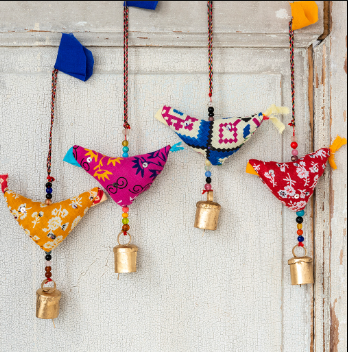      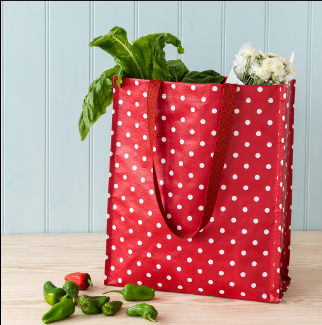    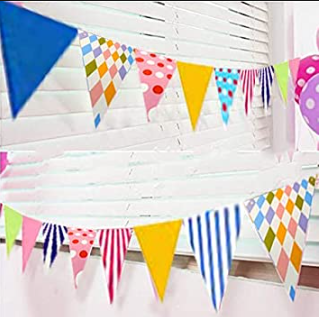